In [1]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [2]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from CNN.module.lib.layers import *
from Faraday.two_dim.module.lib.layers import *

from Faraday.two_dim import matplotlib_style
matplotlib_style.paper()

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.sqrt(x_train.astype("float32") / 255.0)
x_test = np.sqrt(x_test.astype("float32") / 255.0)

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
class SumLikeDetector(tf.keras.layers.Layer):
    def __init__(self, units):
        super(SumLikeDetector, self).__init__()
        self.units = units

    def build(self,input_dim):
        assert input_dim[-1]%self.units == 0
        self.input_dim = input_dim
        filters = np.zeros((self.units, self.input_dim[-1]), dtype=np.float32)
        sum_size = int(self.input_dim[-1]/self.units)
        for i in range(self.units):
            filters[i,sum_size*i:sum_size*(i+1)] = 1.

        self.filters = tf.constant(filters)


    def get_config(self):
        config = super().get_config()
        config.update({
            "units": float(self.units)
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, inputs):
        return tf.tensordot(inputs, self.filters, axes=[-1,-1])

In [5]:
def create_model(shape):
    inputs = tf.keras.Input((28,28))
    x = ImageResizing(shape)(inputs)
    x = layers.Flatten()(x)
    x = Real2Complex()(x)
    x = ComplexDense(30)(x)
    x = MulConjugate()(x)
    x = Real()(x)
    x = SumLikeDetector(10)(x)
    x = tf.keras.layers.Softmax()(x)

    return tf.keras.Model(inputs, x)

In [15]:
def train(i, seed):
    shape = (int(28*i), int(28*i))
    tf.random.set_seed(seed)
    model_name = "20221201/detector(30to30)_seed_{:d}".format(seed)
    path = "/notebooks/"
    checkpoint_path = path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = path + "trained_model/"+ model_name

    model = create_model(shape)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # category: sparse_categorical_crossentropy
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False), "accuracy"]
                  )

    epochs = 30
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [16]:
seeds = [1,2,3,4,5]
for seed in seeds:
    train(0.5, seed)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_8 (ImageResi  (None, 14, 14)           0         
 zing)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 196)               0         
                                                                 
 real2_complex_8 (Real2Compl  (None, 196)              0         
 ex)                                                             
                                                                 
 complex_dense_8 (ComplexDen  (None, 30)               11760     
 se)                                                             
                                                           

In [17]:
import glob
import re

In [33]:
models = glob.glob("/notebooks/trained_model/20221201/*")
models = [s for s in models if re.match(r'.*(lr_schedule|optimizer).*',s) is None]
models.sort()
os.path.basename(models[0])

eval_list = []

for model in models:
    _model = tf.keras.models.load_model(model)
    eval = _model.evaluate(x_test, y_test)
    eval_list.append([os.path.basename(model), *eval])

test_df = pd.DataFrame(eval_list, columns=["name", "loss", "spars_categorical", "acc"])
test_df.to_csv("./normal_eval.csv")

313/313 [==============================] - 1s 2ms/step - loss: 0.1221 - sparse_categorical_crossentropy: 0.1221 - accuracy: 0.9715


In [40]:
np.average(test_df["acc"])

0.971180009841919

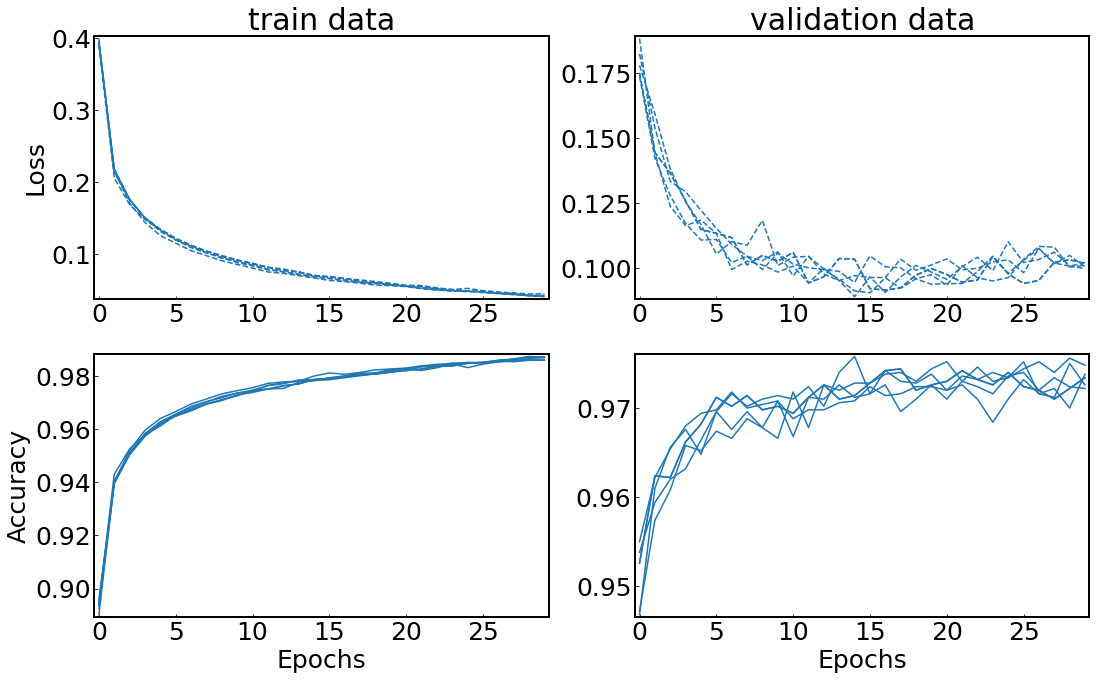

In [39]:
files = glob.glob("/notebooks/trained_model/20221201/*/*.csv")
files.sort()

plt.rcParams['font.size'] = 25
color_dict = {}
index_dict = {}
cmap = plt.get_cmap("tab10")

fig, axes = plt.subplots(2, 2, figsize=(16,10))

for f in files:
    df = pd.read_csv(f)
    shape_group = re.search("detector\(.*\)", f).group()
    if shape_group not in color_dict:
        color_dict[shape_group] = cmap.colors[len(color_dict)]
        axes[0,0].plot(df["loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes[1,0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        axes[0,1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes[1,1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        index_dict[shape_group] = len(index_dict)

    axes[0,0].plot(df["loss"], color=color_dict[shape_group], linestyle="--")
    axes[1,0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-")
    axes[0,1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--")
    axes[1,1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-")

axes[0,0].set_ylabel("Loss")
axes[0,0].set_title("train data")
axes[1,0].set_ylabel("Accuracy")

axes[1,0].set_xlabel("Epochs")
axes[0,1].set_title("validation data")
axes[1,1].set_xlabel("Epochs")


fig.tight_layout()